### Step 1: Load and Explore the Dataset

I'll begin by loading the dataset into a pandas DataFrame and taking a quick look at the first few rows.


In [1]:
import pandas as pd

# Load the dataset
airlines_reviews_df = pd.read_csv('airlines_reviews.csv')

# Display the first few rows of the dataset
airlines_reviews_df.head()


,review
0,The service was excellent. The cabin staff we...
1,We have had some torrid experiences with BA -...
2,We had a flight from ZRH to SFO via LHR. The l...
3,London to Paris. I wish that they would updat...
4,JFK to LHR. Empty check in and priority securi...


### Step 2: Information Retrieval
1. **Sentiment Analysis**: We'll gauge the sentiment of each review. This can be broadly categorized as positive, negative, or neutral.
2. **Category of Complaints**: By using keyword extraction or topic modeling, we can identify common categories of complaints or feedback.
3. **Urgency**: While determining urgency directly from the reviews might be challenging, we can infer urgency by looking for specific keywords or phrases that indicate immediate issues or concerns.
4. **Risks**: We can identify potential risks by searching for keywords that might indicate safety or health concerns.
5. **Other Information**: Depending on the reviews' content, we might identify other patterns or keywords that can provide additional insights.

### Step 3: Define a Pydantic Model
We'll define a Pydantic model to structure the information we retrieve from the reviews. This will ensure that the extracted data is validated and serialized in a consistent manner.

In [2]:
from pydantic import BaseModel
from typing import Optional, List

# Define the schema for the knowledge repository
class ReviewAnalysis(BaseModel):
    sentiment: Optional[str]  # This will be 'Positive', 'Neutral', or 'Negative'
    categories: Optional[List[str]]  # Categories of complaints or feedback
    urgency: Optional[str]  # This will be 'Immediate' or 'Non-Immediate'
    risks: Optional[List[str]]  # List of any risks mentioned
    additional_info: Optional[str]  # Any other useful information extracted from the review

example_review_analysis = ReviewAnalysis(
    sentiment='Positive',
    categories=['In-flight Service'],
    urgency='Non-Immediate',
    risks=[],
    additional_info='Staff were very friendly and accommodating.'
)

example_review_analysis.dict()  # To display how the data is structured according to the schema


{'sentiment': 'Positive',
 'categories': ['In-flight Service'],
 'urgency': 'Non-Immediate',
 'risks': [],
 'additional_info': 'Staff were very friendly and accommodating.'}

The schema for our knowledge repository has been defined using Pydantic. Each ReviewAnalysis object includes:

- **sentiment**: A string that can be 'Positive', 'Neutral', or 'Negative'.
- **categories**: A list of strings representing different categories of complaints or feedback.
- **urgency**: A string that can be 'Immediate' or 'Non-Immediate'.
- **risks**: A list of strings indicating any risks mentioned in the review.
- **additional_info**: A string containing any other useful information extracted from the review.

## Analyse Review

Now we will need to process the dataset to populate instances of ReviewAnalysis with actual data from the reviews. We'll create a function to analyze each review and then apply this function to the dataset.

The function will need to:

- Determine the sentiment of the review.
- Categorize the content of the review.
- Assess urgency and identify any risks.
- Extract any additional relevant information.

In [5]:
from textblob import TextBlob
import re

# Function to analyze each review
def analyze_review(review):
    # Analyze sentiment using TextBlob
    analysis = TextBlob(review)
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Negative' if analysis.sentiment.polarity < 0 else 'Neutral'
    
    # Determine the category based on keywords (very simplistic approach)
    review_categories = []
    categories = {
    "in-flight service": ["cabin", "service", "in-flight", "meal", "food", "beverage", "snack", "drink", "attendant", "catering", "menu", 
                          "quality", "choice", "selection", "dining", "refreshment", "crew service", "presentation", "cuisine", "variety", 
                          "dietary options", "taste", "culinary", "hot meal", "cold meal", "special meal", "onboard service", "flight attendant", 
                          "airline food", "gourmet", "beverage cart", "coffee", "tea", "alcohol", "wine", "beer", "soft drink", "complimentary", 
                          "pay", "purchase", "onboard menu", "breakfast", "lunch", "dinner", "appetizer", "dessert", "main course", "salad", 
                          "vegetarian", "vegan", "gluten-free", "kid's meal", "baby food", "halal", "kosher"],
    "baggage handling": ["baggage", "luggage", "lost", "damaged", "delayed", "check-in", "claim", "carousel", "overhead bin", "carry-on", 
                         "check", "lost and found", "missing", "tag", "weight limit", "excess baggage", "oversize", "fragile", "security", 
                         "handling", "retrieval", "lost property", "baggage service", "locker", "storage", "baggage allowance", "baggage fee", 
                         "hand luggage", "suitcase", "backpack", "duffle bag", "checked luggage", "baggage claim area", "baggage belt", 
                         "tracking", "baggage policy", "baggage handler", "lost luggage office", "airport luggage", "baggage delay", 
                         "baggage damage"],
    "ticketing": ["ticket", "booking", "reservation", "price", "cost", "charge", "fare", "booking fee", "e-ticket", "online booking", "reservation number", 
                  "travel agent", "ticket counter", "boarding pass", "class", "economy", "business", "first class", "upgrade", "discount", "deal", 
                  "offer", "refund", "cancellation", "change fee", "no-show", "itinerary", "round trip", "one way", "direct flight", 
                  "connecting flight", "date change", "seat selection", "booking confirmation", "booking process", "early bird", "last minute", 
                  "flexible ticket", "non-refundable", "refundable", "group booking", "ticket office", "airline website", "booking platform", 
                  "travel website", "promo code", "voucher", "airfare", "ticket price", "booking experience"],
    "seating": ["seat", "legroom", "space", "comfort", "recline", "position", "aisle", "window", "middle seat", "exit row", "bulkhead", 
                "seating arrangement", "seat pitch", "seat width", "armrest", "headrest", "seat cushion", "seat selection", "seat upgrade", 
                "seat map", "seat allocation", "seat preference", "overhead space", "seatbelt", "cabin layout", "economy class seating", 
                "business class seating", "first class seating", "premium economy", "seating comfort", "seat adjustment", "ergonomic seat", 
                "seatback", "underseat storage", "seat reservation", "extra legroom", "cramped", "spacious", "comfortable seating", "uncomfortable seat", 
                "aisle access", "window view", "seat capacity", "cabin class"],
    "staff behavior": ["staff", "crew", "attendant", "rude", "friendly", "helpful", "polite", "unprofessional", "courteous", "attentive", "hostile", 
                       "welcoming", "efficient", "inattentive", "service-oriented", "customer service", "professionalism", "smiling", "interaction", 
                       "crew member", "flight crew", "cabin crew", "airline staff", "customer support", "ground staff", "gate agent", "check-in staff", 
                       "crew attitude", "staff attitude", "crew behavior", "service level", "staff assistance", "crew assistance", "helpfulness", 
                       "responsiveness", "language skills", "communication skills", "problem solving", "empathy", "approachability", "friendliness", 
                       "respectfulness", "teamwork", "crew efficiency", "customer interaction", "personal touch", "staff presence", "service quality", 
                       "staff performance"],
    "delays": ["delay", "late", "wait", "time", "hour", "postponed", "rescheduled", "holdup", "downtime", "flight delay", "boarding delay", 
               "departure delay", "arrival delay", "delayed flight", "long wait", "waiting time", "schedule change", "on-time", "late departure", 
               "late arrival", "delay announcement", "delay reason", "weather delay", "mechanical delay", "air traffic delay", "security delay", 
               "crew delay", "delay compensation", "delayed baggage", "extended wait", "delay notification", "flight status", "schedule disruption", 
               "unforeseen delay", "minor delay", "major delay", "operational delay", "system delay", "ground delay", "gate hold", "tarmac delay", 
               "aircraft delay", "connection delay", "travel disruption", "delayed connection", "prolonged delay"],
    "entertainment": ["entertainment", "screen", "movie", "audio", "headphone", "music", "film", "TV", "television", "game", "in-flight entertainment", 
                      "video", "onboard entertainment", "media", "selection", "content", "entertainment system", "movie selection", "audio channel", 
                      "headset", "earphone", "touch screen", "remote control", "streaming", "Wi-Fi", "internet", "USB port", "power outlet", "app", 
                      "in-flight movie", "TV show", "documentary", "series", "kids entertainment", "entertainment options", "in-flight music", 
                      "audio entertainment", "entertainment quality", "interactive entertainment", "personal screen", "overhead screen", "seatback screen", 
                      "entertainment variety", "onboard Wi-Fi", "in-flight Wi-Fi", "entertainment experience", "flight entertainment", "audio book", 
                      "entertainment library", "multimedia", "video game"],
    "safety": ["safety", "emergency", "seatbelt", "landing", "takeoff", "safety demonstration", "safety video", "flight safety", "aircraft safety", 
               "safety procedures", "safety briefing", "safety measures", "safety equipment", "emergency exit", "life jacket", "oxygen mask", 
               "security procedures", "safety announcement", "evacuation", "safety check", "emergency procedure", "safety instructions", 
               "safety features", "safety protocol", "safety record", "safety standards", "airline safety", "flight attendant safety", 
               "cabin safety", "safety compliance", "safety regulations", "safety guidelines", "safety training", "safety management", 
               "security check", "safety audit", "safety performance", "safety culture", "safety practice", "safety policy", "safety concern", 
               "safety tips", "safety information", "flight security", "safety awareness", "safety priority", "safety announcement", 
               "emergency response"],
    "cleanliness": ["clean", "dirty", "maintained", "hygiene", "sanitary", "tidy", "cleanliness", "unclean", "filthy", "spotless", "disinfect", 
                    "sanitization", "cleaning", "maintenance", "washroom", "bathroom", "restroom", "cabin clean", "hygienic", "litter", "trash", 
                    "waste", "cleaning crew", "cleaning standards", "cleaning service", "dust", "spill", "stain", "cleanliness level", "sanitation", 
                    "germ-free", "neat", "disinfection", "cleaning procedure", "sweep", "mop", "wipe", "cleaner", "cleaning staff", "cleaning policy", 
                    "cleaning frequency", "aircraft cleanliness", "seat cleanliness", "lavatory", "cabin condition", "cleaning supplies", 
                    "surface cleaning", "deep cleaning", "cabin upkeep", "sanitary condition", "hygiene standards", "hygiene practices", 
                    "hygiene level", "cleaning quality", "cleanliness rating"]
}

    for category, keywords in categories.items():
        if any(keyword in review.lower() for keyword in keywords):
            review_categories.append(category)
    
    # Urgency and risks would also typically be determined by keywords or ML models. 
    # For now, we will use simple keywords, this will ofcourse be canged if needed
    urgency_keys = [
        "immediate", "urgent", "critical", "priority", "pressing", "important", "necessary", "essential", "crucial", 
        "prompt", "swift", "rapid", "quick", "hasty", "speedy", "fast", "expedite", "accelerate", "rush", "hurry",
        "asap", "now", "instant", "emergency", "dire", "acute", "demanding", "imperative", "compelling", "serious", 
        "vital", "timely", "sudden", "urgent matter", "urgent issue", "urgent need", "urgent request", "urgent attention", 
        "immediately required", "high priority", "urgent action", "urgent assistance", "urgent help", "urgent response", 
        "urgent service", "urgent support", "urgent treatment", "urgent work", "urgent care", "urgent delivery", 
        "urgent repair", "urgent solution", "urgent handling", "urgent matter", "urgent query", "urgent problem", 
        "urgent situation", "urgent case", "urgent basis", "urgent attention needed", "urgent fix", "urgent resolution", 
        "urgent concern", "urgent call", "urgent demand", "urgent need for action", "urgent follow-up", "urgent response needed",
        "urgent update", "urgent matter", "urgent request"
    ]

    # Assuming review is a string containing the review text
    review_lower = review.lower()
    urgency = 'Immediate' if any(key in review_lower for key in urgency_keys) else 'Non-Immediate'

    
    # Risks might include words like 'danger', 'unsafe', 'risk', 'emergency'
    risk_keywords = [
        'danger', 'unsafe', 'risk', 'emergency', 'hazard', 'threat', 'peril', 'jeopardy', 'alarm', 'warning', 
        'critical', 'serious', 'severe', 'harm', 'damage', 'vulnerable', 'threatening', 'menace', 'risky', 'precarious', 
        'uncertain', 'unsure', 'dubious', 'dicey', 'iffy', 'shaky', 'treacherous', 'adverse', 'insecure', 'unstable', 
        'volatile', 'susceptible', 'exposure', 'liability', 'endanger', 'jeopardize', 'compromise', 'perilous', 'injury', 
        'accident', 'incident', 'mishap', 'breach', 'violation', 'infraction', 'noncompliance', 'contravention', 'transgression', 
        'offense', 'negligence', 'reckless', 'careless', 'irresponsible', 'imprudent', 'unwise', 'ill-advised', 'imperil', 
        'catastrophe', 'disaster', 'calamity', 'tragedy', 'crisis', 'emergency situation', 'unsafe conditions', 'hazardous', 
        'fatal', 'lethal', 'deadly', 'mortal', 'toxic', 'contamination', 'pollution', 'spill', 'leak', 'outbreak', 'pandemic', 
        'epidemic', 'infectious', 'contagious', 'health hazard', 'safety hazard', 'security risk', 'cyber risk', 'financial risk'
    ]

    risks = [word for word in risk_keywords if word in review.lower()]
    
    # For additional info, we might extract anything in quotes as a simple proxy for specific comments.
    additional_info = ' '.join(re.findall(r'"(.*?)"', review))
    
    return ReviewAnalysis(
        sentiment=sentiment,
        categories=tuple(review_categories),
        urgency=urgency,
        risks=risks,
        additional_info=additional_info
    )

# Apply the function to a small subset of the dataset to test it
sample_reviews_analysis = airlines_reviews_df['review'].head().apply(analyze_review)
sample_reviews_analysis.tolist()


[ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'seating', 'staff behavior'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'baggage handling', 'ticketing', 'seating', 'staff behavior', 'delays'], urgency='Immediate', risks=['harm'], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'staff behavior', 'entertainment', 'cleanliness'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'ticketing', 'seating'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'baggage handling', 'ticketing', 'staff behavior', 'delays', 'entertainment'], urgency='Immediate', risks=[], additional_info='')]

In the above output, for each review, we have:

- **sentiment**: Determined as 'Positive' or 'Negative' based on the polarity of the text.
- **categories**: Identified based on predefined keywords related to common airline service categories.
- **urgency**: Assessed as 'Immediate' or 'Non-Immediate' based on specific keywords in the text.
- **risks**: Identified by the presence of risk-related keywords.
- **additional_info**: Extracted as text within quotes.

In [6]:
# Let's check the size of the dataset to decide how to proceed
dataset_size = len(airlines_reviews_df)
dataset_size


500

The dataset contains 500 reviews, which is a manageable size for processing in one go without the need for chunking. We'll apply the analysis function to the entire dataset, store the results in a new DataFrame, and then extract insights.

In [7]:
# Apply the analysis to the entire dataset
full_reviews_analysis = airlines_reviews_df['review'].apply(analyze_review)

# Convert the list of ReviewAnalysis objects to a list of dictionaries and then to a DataFrame
analysis_dicts = [analysis.dict() for analysis in full_reviews_analysis]
analysis_df = pd.DataFrame(analysis_dicts)

analysis_df.head()


,sentiment,categories,urgency,risks,additional_info
0,Positive,"[in-flight service, seating, staff behavior]",Non-Immediate,[],
1,Positive,"[in-flight service, baggage handling, ticketin...",Immediate,[harm],
2,Positive,"[in-flight service, staff behavior, entertainm...",Non-Immediate,[],
3,Positive,"[in-flight service, ticketing, seating]",Non-Immediate,[],
4,Positive,"[in-flight service, baggage handling, ticketin...",Immediate,[],


In [8]:
analysis_df.to_csv('airline_reviews_updated.csv')

The analysis results have been successfully structured into a pandas DataFrame. The DataFrame includes columns for sentiment, categories, urgency, risks, and additional_info based on the content of each review.

In [9]:

# The distribution of sentiments across all reviews.
sentiment_distribution = analysis_df['sentiment'].value_counts(normalize=True) * 100



In [10]:
import ast

def safe_literal_eval(s):
    try:
        # Only try to evaluate non-empty strings that start with a character that indicates a Python literal.
        if isinstance(s, str) and (s.startswith(('[', '{', '"', "'")) or s.isdigit()):
            return ast.literal_eval(s)
        elif s == '[]':  # If the string is exactly '[]', return an empty list
            return []
    except (ValueError, SyntaxError):
        # If there's an error in evaluating, just return the string as-is
        pass
    return str(s)

In [11]:
# Apply the safe_literal_eval function to 'categories' and 'risks' columns
analysis_df['categories'] = analysis_df['categories'].apply(safe_literal_eval)
analysis_df['risks'] = analysis_df['risks'].apply(safe_literal_eval)


In [12]:
ast.literal_eval(str(analysis_df['categories'][0]))

['in-flight service', 'seating', 'staff behavior']

In [13]:
# The most common categories for complaints or feedback.
# Since the categories are in a list within a string, we'll first convert them to actual lists

analysis_df['categories'] = analysis_df['categories'].apply(ast.literal_eval)
# Now we can explode the categories into separate rows and count the occurrences
category_distribution = analysis_df.explode('categories')['categories'].value_counts()




In [14]:
# The frequency of urgent versus non-urgent feedback.
urgency_distribution = analysis_df['urgency'].value_counts(normalize=True) * 100

# Similar to categories, we'll convert the risks from string representation of lists to actual lists
analysis_df['risks'] = analysis_df['risks'].apply(ast.literal_eval)
risk_distribution = analysis_df.explode('risks')['risks'].value_counts()

# Display the generated insights
(sentiment_distribution, category_distribution, urgency_distribution, risk_distribution)

(Positive    73.0
 Negative    26.8
 Neutral      0.2
 Name: sentiment, dtype: float64,
 in-flight service    454
 ticketing            369
 delays               363
 staff behavior       358
 seating              330
 entertainment        266
 baggage handling     257
 cleanliness           99
 safety                51
 Name: categories, dtype: int64,
 Non-Immediate    52.8
 Immediate        47.2
 Name: urgency, dtype: float64,
 emergency      5
 risk           5
 severe         4
 disaster       4
 serious        3
 harm           3
 hazard         2
 warning        2
 damage         2
 liability      2
 alarm          1
 unsafe         1
 accident       1
 pandemic       1
 danger         1
 threat         1
 threatening    1
 careless       1
 Name: risks, dtype: int64)

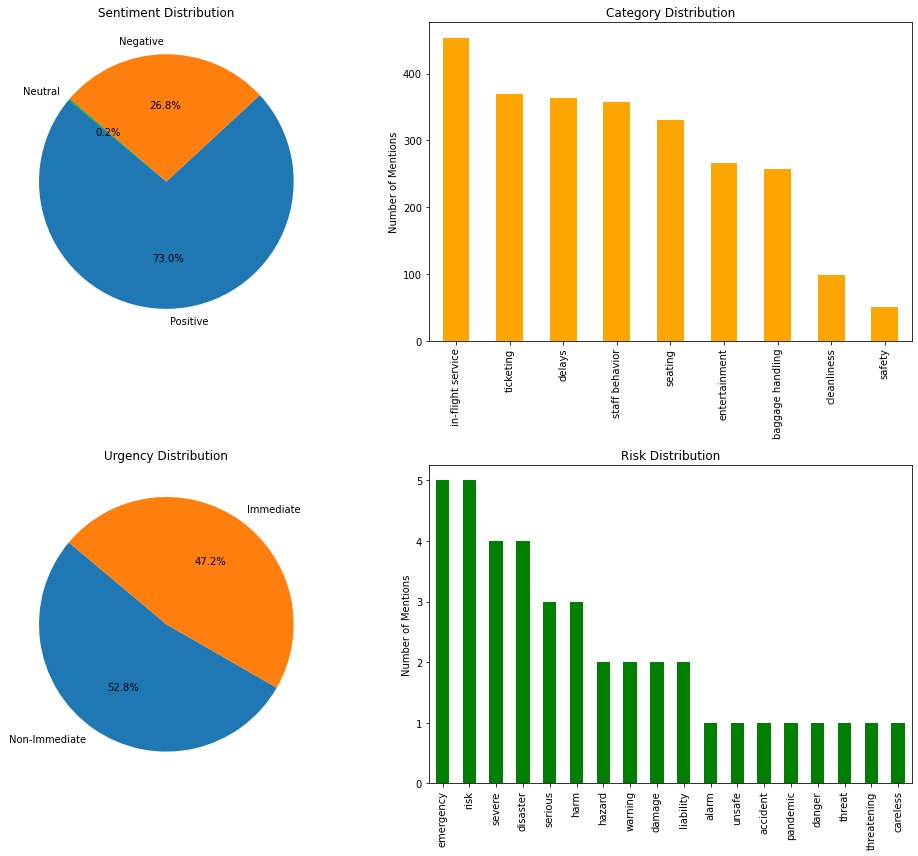

In [15]:
import matplotlib.pyplot as plt

# Set up the figure and axes for the visualizations
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Sentiment Distribution Pie Chart
axs[0, 0].pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
axs[0, 0].set_title('Sentiment Distribution')

# Category Distribution Bar Chart
category_distribution.plot(kind='bar', ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Category Distribution')
axs[0, 1].set_ylabel('Number of Mentions')

# Urgency Distribution Pie Chart
axs[1, 0].pie(urgency_distribution, labels=urgency_distribution.index, autopct='%1.1f%%', startangle=140)
axs[1, 0].set_title('Urgency Distribution')

# Risks Distribution Bar Chart
risk_distribution.plot(kind='bar', ax=axs[1, 1], color='green')
axs[1, 1].set_title('Risk Distribution')
axs[1, 1].set_ylabel('Number of Mentions')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [16]:
# Since risks are in a list format in each row, we'll check if any row contains non-empty lists
risks_present = analysis_df['risks'].apply(lambda risks: len(risks) > 0)

# Count how many reviews have mentioned risks
number_of_risks = risks_present.sum()

# Output the number of reviews mentioning risks
number_of_risks


37

In [17]:
# First, we'll see how many reviews contain additional information
additional_info_present = analysis_df['additional_info'].apply(lambda info: len(info.strip()) > 0)

# Count how many reviews have additional information
number_of_additional_info = additional_info_present.sum()

# Show some examples of the additional information provided, if available
additional_info_examples = analysis_df[analysis_df['additional_info'] != '']['additional_info'].head(10).tolist()

number_of_additional_info, additional_info_examples


(116,
 ["Compared to the likes of EVA Air or Qatar Airways, British Airways Club World is by far the poor relation. Flew from Glasgow to New York via LHR, the seats have zero storage apart from the small drawer at floor level. It is astonishing that for the money they charge, you have to step over the legs of the person on your outside, especially if you accidentally trip and land on top of them. Food was satisfactory although a small bacon roll for breakfast was again a poor show. AVOD was also satisfactory. Apart from the flat bed, this just really doesn't have a premium feel about it. On our recent trip, on both legs, the crew were excellent, but the product from our national flag carrier simply is not worth the premium prices they charge.",
  'LHR-Washington on a 777-200. Trip got off to a good start in the BA Concorde 1st Class lounge. Nice champagne and a nice quiet ambiance which I like. The place is starting to show signs of wear and tear - with sagging seat cushions. Plane was

In [18]:
analysis_df.head()

,sentiment,categories,urgency,risks,additional_info
0,Positive,"[in-flight service, seating, staff behavior]",Non-Immediate,[],
1,Positive,"[in-flight service, baggage handling, ticketin...",Immediate,[harm],
2,Positive,"[in-flight service, staff behavior, entertainm...",Non-Immediate,[],
3,Positive,"[in-flight service, ticketing, seating]",Non-Immediate,[],
4,Positive,"[in-flight service, baggage handling, ticketin...",Immediate,[],


In [19]:
# Apply safe_literal_eval function to 'categories' and 'risks' columns
analysis_df['categories'] = analysis_df['categories'].apply(safe_literal_eval)
analysis_df['risks'] = analysis_df['risks'].apply(safe_literal_eval)

# Add a new column that counts the number of categories mentioned in each review
analysis_df['category_count'] = analysis_df['categories'].apply(len)

# Add a new column that counts the number of risks mentioned in each review
analysis_df['risk_count'] = analysis_df['risks'].apply(len)

# Now we'll convert categorical columns to numerical values for correlation analysis
# For sentiment, we'll map Positive to 1, Neutral to 0, and Negative to -1
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
analysis_df['sentiment_score'] = analysis_df['sentiment'].map(sentiment_mapping)

# For urgency, we'll map Immediate to 1 and Non-Immediate to 0
urgency_mapping = {'Immediate': 1, 'Non-Immediate': 0}
analysis_df['urgency_score'] = analysis_df['urgency'].map(urgency_mapping)

# Now we can calculate correlations
correlation_matrix = analysis_df[['sentiment_score', 'urgency_score', 'category_count', 'risk_count']].corr()

correlation_matrix


,sentiment_score,urgency_score,category_count,risk_count
sentiment_score,1.000000,0.031517,0.071408,0.028677
urgency_score,0.031517,1.000000,0.248460,0.129834
category_count,0.071408,0.248460,1.000000,0.053424
risk_count,0.028677,0.129834,0.053424,1.000000


1. **Sentiment Score**:
   - The sentiment score has a very low positive correlation with the urgency score (\(0.031517\)), indicating that the sentiment of the feedback (positive, neutral, negative) has very little to do with the urgency assigned to it.
   - There is a low positive correlation between the sentiment score and the category count (\(0.071408\)), which could imply that feedback with a higher number of categories mentioned is slightly more likely to be positive, but the correlation is still weak.
   - The sentiment score has a very low positive correlation with the risk count (\(0.028677\)), suggesting that the presence of risks in the feedback doesn't strongly influence whether the sentiment is positive or negative.

2. **Urgency Score**:
   - As already noted, there's a very low positive correlation between urgency score and sentiment score.
   - There is a moderate positive correlation between the urgency score and the category count (\(0.248460\)), suggesting that feedback mentioning more categories is somewhat more likely to be marked as urgent. This makes sense as feedback concerning multiple areas might require more immediate attention.
   - The urgency score has a low positive correlation with the risk count (\(0.129834\)), implying that feedback with identified risks is somewhat more likely to be considered urgent, which aligns with what one might expect intuitively.

3. **Category Count**:
   - There is a low positive correlation between the category count and both the sentiment score and the urgency score, as mentioned above.
   - The category count has a very low positive correlation with the risk count (\(0.053424\)), suggesting that having more categories mentioned in the feedback doesn't significantly increase the likelihood that risks will be identified.

4. **Risk Count**:
   - The correlations of the risk count with both the sentiment score and the category count are very low, indicating that the number of risks identified in feedback is mostly independent of the sentiment and the number of categories mentioned.


### Prompt engineering

In [20]:
from langchain.llms import OpenAI
from langchain import PromptTemplate, LLMChain

import json
import os

In [21]:
# we have avoided removing full stops to keep the itentity of sentences

def clean_text(text):
    cleaned_text = ''
    for char in text:
        if char.isalnum() or char.isspace() or char == '.':
            cleaned_text += char
    return cleaned_text



In [22]:
with open('api_keys.json') as api_file:
    api_dict = json.load(api_file)

os.environ['OPENAI_API_KEY'] = api_dict['API OPENAI']

In [23]:
# Initialize the language model
llm = OpenAI()


In [58]:
template_for_code = """
Give me the sentiment, risk, urgency, Topic, Source Airport, Destination Airport, Carrier of the given review:


Review:
    {review}

Instructions:
    1. Be very specific to the review I provided
    2. Do not refer to anything else external from the source

Answer in following format: 
            <sentiment>, <risk>, <urgency>, <topic>, <source>, <destination>, <carrier>

Good examples are: 
            Positive, High Risk, Non-Immediate, Bad Service, City x, City y, Air India

"""

In [59]:
airlines_reviews_df.review[0]

' The service was excellent. The cabin staff were attentive and efficient. The food and drinks were very good. The seat in the new suites is extremely comfortable and the additional privacy is really nice. Overall a very enjoyable flight.\n'

In [60]:
prompt_repo = PromptTemplate(
    template = template_for_code,
    input_variables=['review']
)
review = airlines_reviews_df.review[100]



In [65]:
# Create a LLMChain instance for generating the summary of the repository
llm_chain = LLMChain(prompt=prompt_repo, llm=llm)
answer_openai = llm_chain.run(
    review = review,
)
print(answer_openai)

Negative, Low Risk, Non-Immediate, Bad Seating, CAI, LHR, JFK, Carrier x


In [66]:
analysis_df.shape[0]

500

In [67]:
columns = ['Sentiment', 'Risk', 'Urgency', 'Topic', 'Source Airport', 'Destination Airport', 'Carrier']

data_df = pd.DataFrame(columns = columns)

In [68]:
for i in range(airlines_reviews_df.shape[0]):
    # values = [item.strip() for item in entry.split(',')]
    review = airlines_reviews_df.iloc[i, 0]
    print(f'review no: {i + 1}')
    answer_openai = llm_chain.run(
        review = review,
    )
    values = [item.strip() for item in answer_openai.split(',')]

    # data_df = data_df.append(pd.Series(values, index = columns), ignore_index=True)

    try:
        row_df = pd.DataFrame([values], columns=columns)
        data_df = pd.concat([data_df, row_df], ignore_index=True)
    except:
        row_df = pd.DataFrame([[None, None, None, None, None, None, None]], columns=columns)
        data_df = pd.concat([data_df, row_df], ignore_index=True)

data_df.head()


review no: 1
review no: 2
review no: 3
review no: 4
review no: 5
review no: 6
review no: 7
review no: 8
review no: 9
review no: 10
review no: 11
review no: 12
review no: 13
review no: 14
review no: 15
review no: 16
review no: 17
review no: 18
review no: 19
review no: 20
review no: 21
review no: 22
review no: 23
review no: 24
review no: 25
review no: 26
review no: 27
review no: 28
review no: 29
review no: 30
review no: 31
review no: 32
review no: 33
review no: 34
review no: 35
review no: 36
review no: 37
review no: 38
review no: 39
review no: 40
review no: 41
review no: 42
review no: 43
review no: 44
review no: 45
review no: 46
review no: 47
review no: 48
review no: 49
review no: 50
review no: 51
review no: 52
review no: 53
review no: 54
review no: 55
review no: 56
review no: 57
review no: 58
review no: 59
review no: 60
review no: 61
review no: 62
review no: 63
review no: 64
review no: 65
review no: 66
review no: 67
review no: 68
review no: 69
review no: 70
review no: 71
review no: 72
r

,Sentiment,Risk,Urgency,Topic,Source Airport,Destination Airport,Carrier
0,Positive,Low Risk,Non-Immediate,Good Service,Unknown,Unknown,Unknown
1,Positive,Low Risk,Non-Immediate,Good Service,Heathrow,Austin,British Airways
2,Positive,Low Risk,Non-Immediate,Good Service,Zurich Airport (ZRH),San Francisco Airport (SFO),British Airways (BA)
3,Negative,Low Risk,Immediate,Refurbishing,London,Paris,Low-cost Carrier
4,Positive,Low Risk,Non-Immediate,Good Service,JFK,LHR,Unknown


In [69]:
data_df.to_csv('airline_review_classified.csv')

,Sentiment,Risk,Urgency,Topic,Source Airport,Destination Airport,Carrier
0,Positive,Low Risk,Non-Immediate,Good Service,Unknown,Unknown,Unknown
1,Positive,Low Risk,Non-Immediate,Good Service,Heathrow,Austin,British Airways
2,Positive,Low Risk,Non-Immediate,Good Service,Zurich Airport (ZRH),San Francisco Airport (SFO),British Airways (BA)
3,Negative,Low Risk,Immediate,Refurbishing,London,Paris,Low-cost Carrier
4,Positive,Low Risk,Non-Immediate,Good Service,JFK,LHR,Unknown
...,...,...,...,...,...,...,...
495,Negative,Low Risk,Immediate,Poor Aircraft Condition,London,New York JFK,Brussels Airlines
496,Positive,Low Risk,Non-Immediate,Good Service,Manchester,Heathrow,Unknown
497,Positive,Low Risk,Non-Immediate,Good Service,Zurich,London Heathrow,British Airways
498,Negative,Low Risk,Non-Immediate,Flight Quality,Pisa,Chicago,American Airlines


In [93]:
data_df['Sentiment'].unique()

array(['Positive', 'Negative', 'Neutral', 'Answer: Positive', None,
       'Pleasant', 'Answer: Negative', 'Indifferent'], dtype=object)

In [96]:
data_df['Risk'].unique()

array(['Low Risk', 'Moderate Risk', 'High Risk', None, 'Medium Risk',
       'No Risk', 'Low-Risk'], dtype=object)

In [95]:
data_df['Urgency'].unique()

array(['Non-Immediate', 'Immediate', None], dtype=object)

In [70]:
data_df.to_csv('airline_review_classified.csv')

In [97]:
filtered_df = data_df[data_df['Carrier'].str.contains('British', na=False)]


In [98]:

def normalize_values(data_df):
    # Normalize 'Sentiment' values
    sentiment_mapping = {
        'Positive': ['Positive', 'Answer: Positive', 'Pleasant'],
        'Negative': ['Negative', 'Answer: Negative'],
        'Neutral': ['Neutral', 'Indifferent'],
        None: ['Unknown'] 
    }
    
    # Normalize 'Risk' values
    risk_mapping = {
        'Low Risk': ['Low Risk', 'Low-Risk', 'No Risk'],
        'Moderate Risk': ['Moderate Risk', 'Medium Risk'],
        'High Risk': ['High Risk'],
        None: ['Unknown'] 
    }

    # Normalize 'Urgency' values
    urgency_mapping = {
        'Non-Immediate': ['Non-Immediate'],
        'Immediate': ['Immediate'],
        None: ['Unknown'] 
    }

    # Helper function for mapping
    def map_values(row, mapping):
        for key, values in mapping.items():
            if row in values:
                return key
        return row

    # Apply mappings
    data_df['Sentiment'] = data_df['Sentiment'].apply(lambda x: map_values(x, sentiment_mapping))
    data_df['Risk'] = data_df['Risk'].apply(lambda x: map_values(x, risk_mapping))
    data_df['Urgency'] = data_df['Urgency'].apply(lambda x: map_values(x, urgency_mapping))

    return data_df


filtered_df = normalize_values(filtered_df)


/var/folders/d0/s7smb0291jd470mxvk1bfhb00000gn/T/ipykernel_8963/1427655299.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Sentiment'] = data_df['Sentiment'].apply(lambda x: map_values(x, sentiment_mapping))
/var/folders/d0/s7smb0291jd470mxvk1bfhb00000gn/T/ipykernel_8963/1427655299.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Risk'] = data_df['Risk'].apply(lambda x: map_values(x, risk_mapping))
/var/folders/d0/s7smb0291jd470mxvk1bfhb00000gn/T/ipykernel_8963/1427655299.py:35: S

In [99]:
filtered_df.head()

,Sentiment,Risk,Urgency,Topic,Source Airport,Destination Airport,Carrier
1,Positive,Low Risk,Non-Immediate,Good Service,Heathrow,Austin,British Airways
2,Positive,Low Risk,Non-Immediate,Good Service,Zurich Airport (ZRH),San Francisco Airport (SFO),British Airways (BA)
5,Negative,Low Risk,Immediate,Poor Timing,London Heathrow,Cape Town,British Airways
6,Positive,Low Risk,Non-Immediate,Good Service,London City,Florence,British Airways
7,Negative,Low Risk,Immediate,Food Quality,Singapore,London Heathrow,British Airways


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Overview of distribution of feedback by sentiment, risk, urgency, topic for every Career
def plot_distribution_by_career(data_df, career_column):
    features = ['Sentiment', 'Risk', 'Urgency', 'Topic']
    top_careers = data_df[career_column].value_counts().index[:3]  # Get top 3 careers
    filtered_df = data_df[data_df[career_column].isin(top_careers)]  # Filter DataFrame

    for feature in features:
        plt.figure(figsize=(20, 6))
        sns.countplot(x=feature, data=filtered_df)
        plt.xticks(rotation = 90)
        plt.title(f'Distribution of {feature} by {career_column}')
        plt.show()



# 2. Overview of distribution of feedback by sentiment, risk, urgency, topic for every source airport
def plot_distribution_by_source_airport(data_df):
    features = ['Sentiment', 'Risk', 'Urgency', 'Topic']
    top_airports = data_df['Source Airport'].value_counts().index[:3]  # Get top 3 airports
    filtered_df = data_df[data_df['Source Airport'].isin(top_airports)]  # Filter DataFrame

    for feature in features:
        plt.figure(figsize=(20, 6))
        sns.countplot(x=feature, data=filtered_df)
        plt.xticks(rotation = 90)
        plt.title(f'Distribution of {feature} by Source Airport')
        plt.show()

# 3. Identifying top things customers like and airline should continue offering
def top_positive_feedback(data_df):
    """
    This function identifies the top positive aspects that customers like.
    """
    # Assuming positive sentiment is labeled in a certain way (e.g., 'Positive')
    positive_feedback = data_df[data_df['Sentiment'] == 'Positive']
    top_topics = positive_feedback['Topic'].value_counts().head(5)
    return top_topics

# 4. Identifying top pain points from the reviews
def top_pain_points(data_df):
    """
    This function identifies the top pain points mentioned in the reviews.
    """
    # Assuming negative sentiment is labeled in a certain way (e.g., 'Negative')
    negative_feedback = data_df[data_df['Sentiment'] == 'Negative']
    pain_points = negative_feedback['Topic'].value_counts().head(5)
    return pain_points



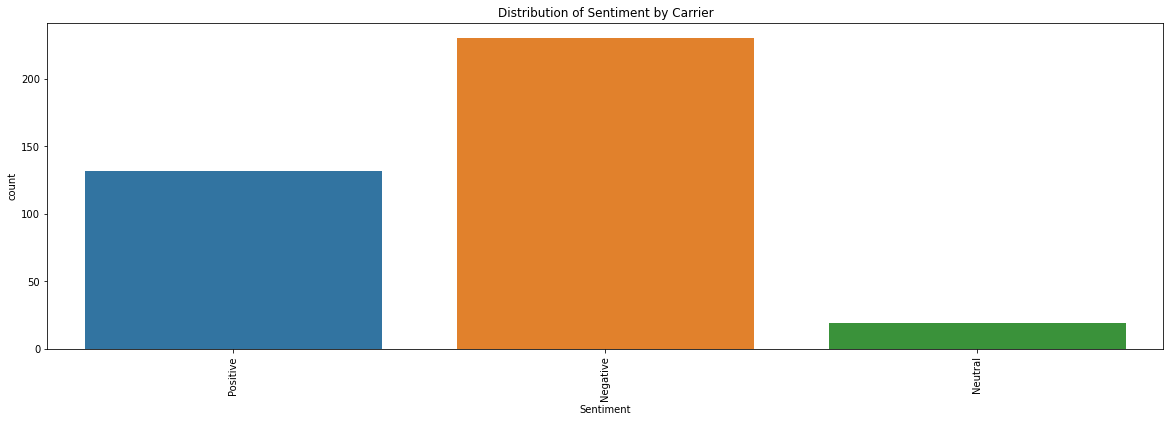

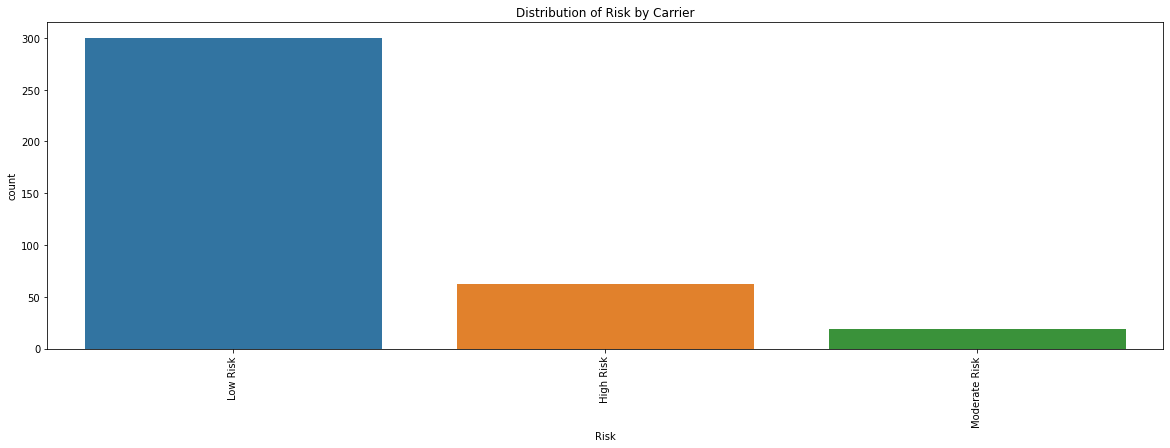

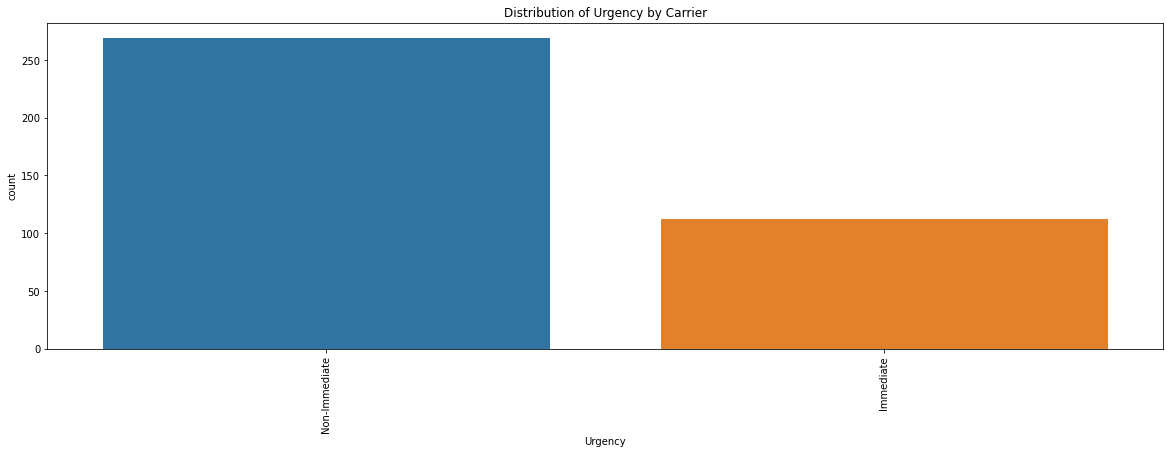

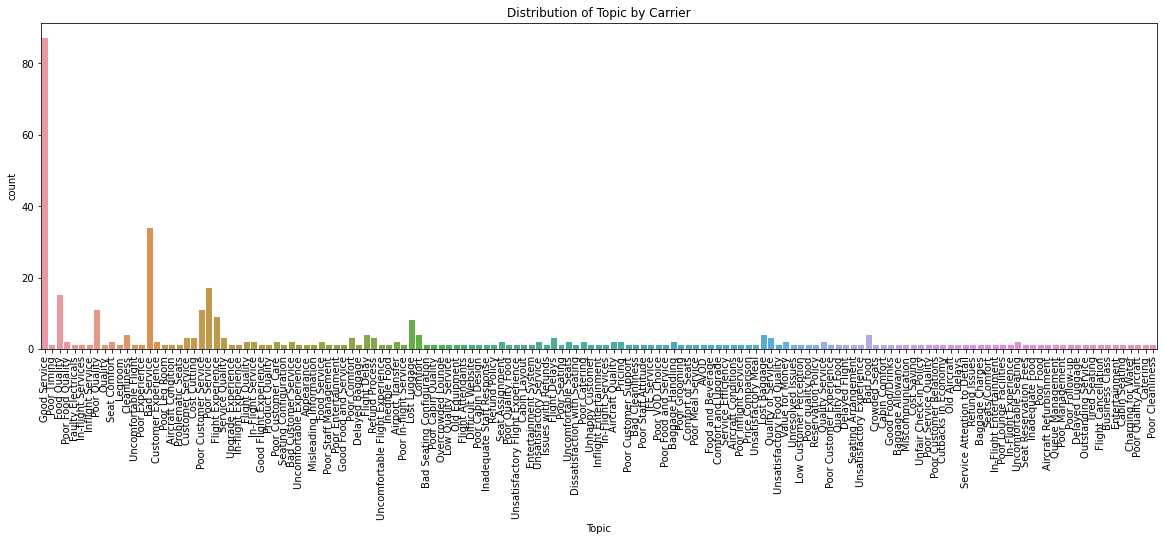

In [104]:
plot_distribution_by_career(filtered_df, 'Carrier')

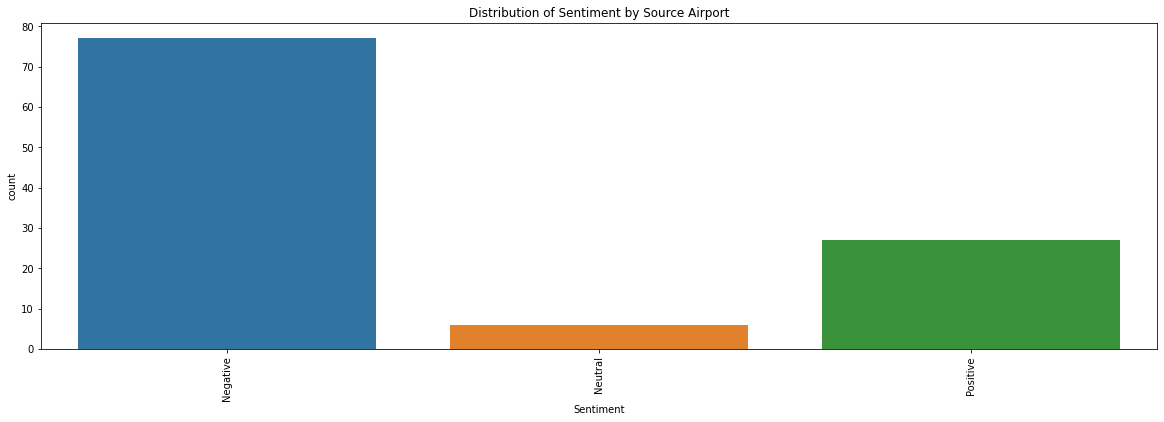

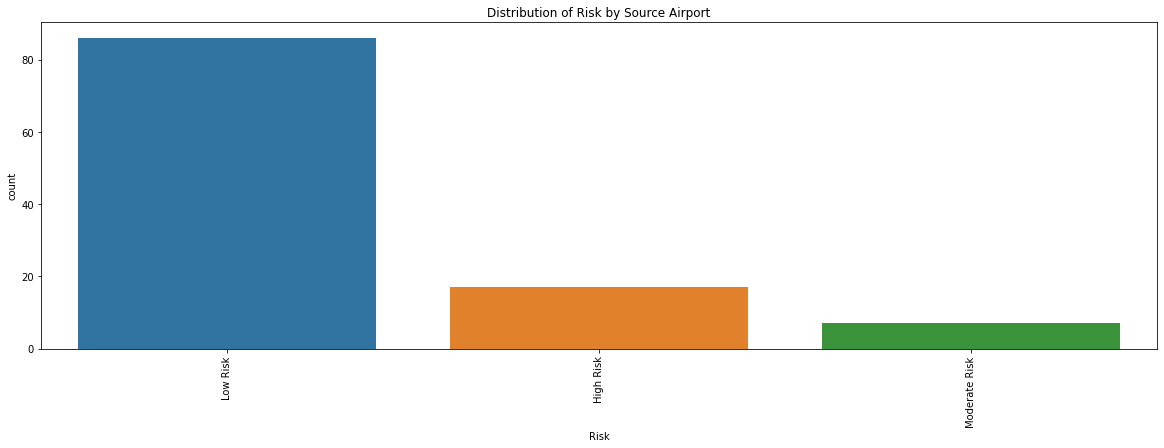

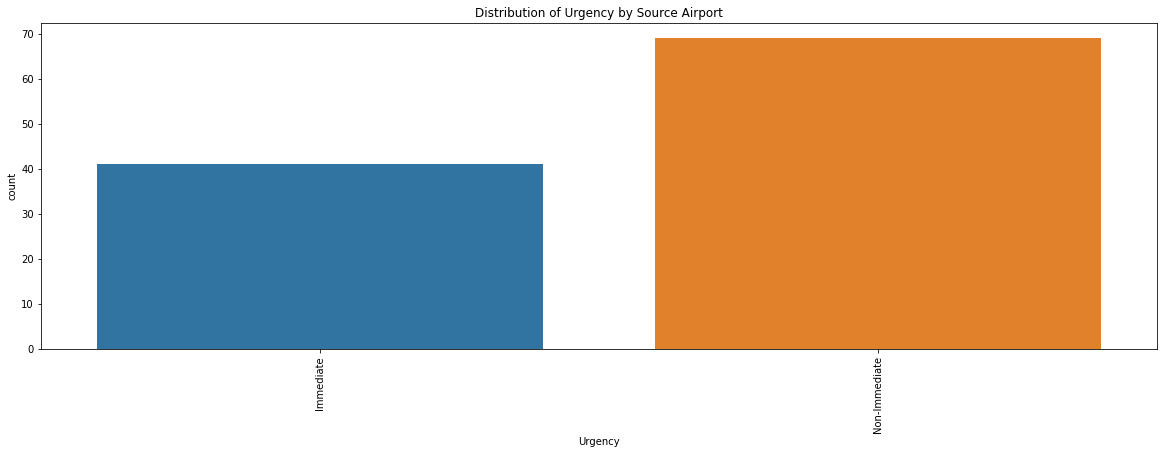

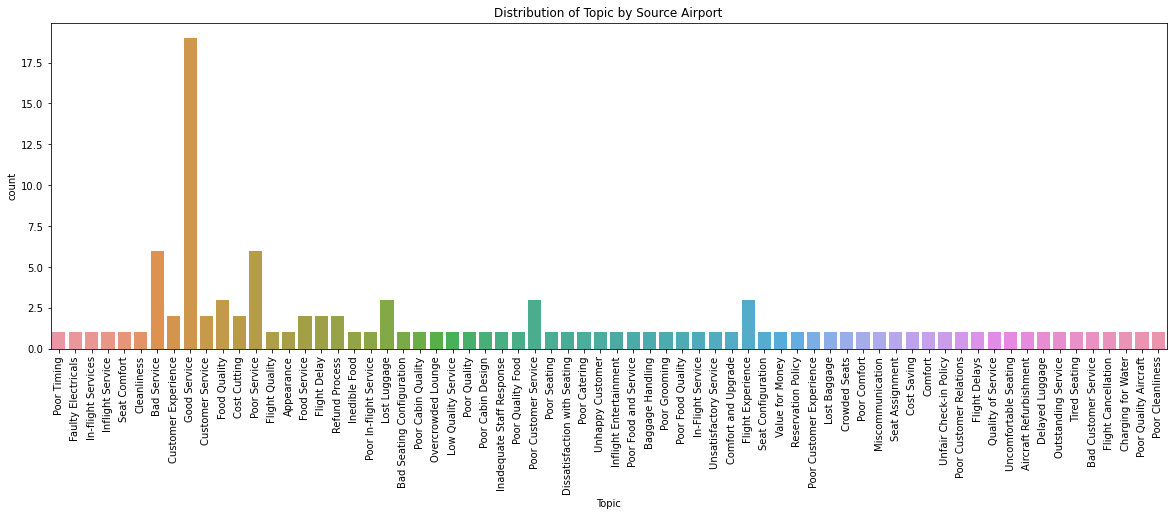

In [105]:
plot_distribution_by_source_airport(filtered_df)

In [106]:
top_positive_feedback(filtered_df)

Good Service         89
Flight Experience     7
Bad Service           3
Service Quality       2
Aircraft Quality      2
Name: Topic, dtype: int64

In [107]:
top_pain_points(filtered_df)

Bad Service              31
Poor Service             17
Food Quality             15
Poor Customer Service    12
Poor Quality             11
Name: Topic, dtype: int64